In [1]:
import os

for dir_name, _, filenames in os.walk('/kaggle/input'): #iterate through the input section of kaggle and unload into variable names provided
    for filename in filenames: #iterate through filenames and unload each iteration output into filename
        print(os.path.join(dir_name, filename)) #safely join both variables together.

/kaggle/input/asrs-nasa/asrs.csv
/kaggle/input/nasa-asrs-aviation-safety-reporting-system/__results__.html
/kaggle/input/nasa-asrs-aviation-safety-reporting-system/__huggingface_repos__.json
/kaggle/input/nasa-asrs-aviation-safety-reporting-system/__notebook__.ipynb
/kaggle/input/nasa-asrs-aviation-safety-reporting-system/__output__.json
/kaggle/input/nasa-asrs-aviation-safety-reporting-system/custom.css
/kaggle/input/nasa-asrs-aviation-safety-reporting-system/__results___files/__results___13_0.png


# Abstract:

This project introduces a prototype AI fault assistant that leverages transformer models to retrieve semantically similar aviation incident reports from the NASA ASRS dataset using embeddings on cleaned and processed narrative text. Using SBERT and computing similarity scores through cosine distance, the system enables engineers to quickly surface conceptually related incidents without relying on exact word overlap. A sample of 1000 incidents was used from the ASRS aviation safety reports to demonstrate the working model.

The project combines NLP implementation with practical safety analysis, aiming to reduce the time from incident report to closure. By surfacing relevant prior reports, the assistant can guide engineers on the appropriate steps to take — ultimately reducing the need for extensive training and lowering the time and cost of incident investigation processes.

# Introduction

In industry, incident reports can be time-consuming and costly, often taking days and numerous exchanges to reach a closure analysis. This results in hours of Non-Productive Time (NPT), a critical cost factor in sectors where delays can impact safety and operations. Most incident reports are unstructured narratives, which vary significantly in phrasing and style.

This project explores whether recent advances in sentence-level language models can support a more intelligent approach to transforming unstructured incident analysis into actionable closure recommendations.

By applying Sentence-BERT (SBERT) to a cleaned subset of the NASA Aviation Safety Reporting System dataset, this project builds a lightweight assistant capable of returning semantically similar narratives based on a single query. This allows engineers to learn from similar past incidents and quickly identify relevant closure steps. Cosine similarity is used to match high-dimensional embeddings, and t-SNE visualisation was employed to interpret how well narratives cluster.

This work was inspired by conversations with professionals in engineering and safety-critical sectors, including those at a global leader in drilling tools and industrial solutions. Their insights into high-stakes environments — where misdiagnosis of faults can lead to costly downtime or safety risks — revealed a critical opportunity to reduce investigation delays and support engineers through intelligent similarity-based systems.


In [2]:
#load the file in /kaggle/input:
import pandas as pd 
import numpy as np
np.seterr(invalid='ignore') #Note made of this being used to safely supress RuntimeWarnings as I have already 

df = pd.read_csv('/kaggle/input/asrs-nasa/asrs.csv', low_memory = False) #load the csv file as read only from the filepath
#error occured suggested: use low_memory = False to handle mixed dtypes


#Note: low_memory=False ensures that memory optimisation does not conflict with correct dtype inference when dealing with mixed dtypes.
# Initial preview and shape of the DF:
print(f"Data Dimensions (rows, columns): {df.shape}")
print("FIRST THREE ROWS: \n", df.head(3))
print("\nLAST THREE ROWS: \n", df.tail(3))


#duplicate rows detected: drop both duplicate columns:
df.drop(['Narrative.1', 'Callback.1'], axis=1, inplace=True) # drop both duplicate columns (directly modified df)
# Note: inplace=True directly modifies the DF 'inplace' so the DF is directly being cleaned

# Note: Observed and have made note of NaN values - will safely suppress warnings for cleaner and more readable kernel.
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#df.head() #Note: Gives readable, easy and clear view of the DF

Data Dimensions (rows, columns): (225080, 116)
FIRST THREE ROWS: 
      ACN  Year  Month Local Time Of Day Locale Reference State Reference  \
0  79866  1988      1         1801-2400              CVG              OH   
1  79912  1988      1         1201-1800         SEA; BFI              WA   
2  79965  1988      1         1201-1800              DEN              CO   

   Relative Position.Angle.Radial  Relative Position.Distance.Nautical Miles  \
0                            60.0                                       35.0   
1                             NaN                                        6.0   
2                             NaN                                       20.0   

  Altitude.AGL.Single Value Altitude.MSL.Single Value  ...  \
0                       NaN                   31000.0  ...   
1                       NaN                     900.0  ...   
2                       NaN                    7500.0  ...   

                                            Detector When 

#### Note:
-  NaN values present - this will result in RuntimeWarnings later if not handled properly.
-  The contributing factors/situations and primary problem columns seem to be identical for both:
-         .head(3)
-         .tail(3)
>Worth investigating to prevent redundancy and messiness.

In [3]:
#inspect the data (Structure + missing values)
df.info() #to see the structure of the dataset

#count missing values per column, sorted by the most missing values first.
print(df.isnull().sum().sort_values(ascending=False))

#find the percentage of each missing value in the column if: >10% then: drop
for col in df.columns:
    missing = df[col].isnull().sum()
    total = len(df[col])
    percentage = (missing/total) * 100
    print(f"Percentage of missing values in {col} is: \n{percentage}%")
    if percentage>10:
        df.drop(columns = [col], inplace = True)
        print(f"Dropped: {col} - 10% threshold surpassed")

#df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225080 entries, 0 to 225079
Columns: 114 entries, ACN to Synopsis
dtypes: float64(9), int64(3), object(102)
memory usage: 195.8+ MB
Flight Operated As (UAS).1                                       225079
Operating Under Waivers / Exemptions / Authorizations (UAS).1    225078
UAS Communication Breakdown.1                                    225078
Waivers / Exemptions / Authorizations (UAS).1                    225077
Aircraft Zone                                                    225073
                                                                  ...  
Narrative                                                             0
ACN                                                                   0
Year                                                                  0
Month                                                                 0
Synopsis                                                              0
Length: 114, dtype: int64


### Note 
Large number of columns were dropped due the threshold potentially being too low, which could affect the clustering accuracy results.

In [4]:
#cleaning narrative field - make text usable
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


def cleanup_text(text):
    if pd.isna(text):
        return "" #if the text is NaN replace with empty string
    text = text.lower()
    text = re.sub(r'\d+', '', text) #identifies numbers and replaces them with whitespace 
    text = re.sub(r'[^\w\s]', '', text) # identifies punctuation and replaces with whitespace 
    text = re.sub(r'\s+', ' ', text).strip() # normalises multiple whitespace
    #iterate through the split text and unload into word, return the word if its not in stop_words (stopwords won't be returned)
    cleanedup = ' '.join([word for word in text.split() if word not in stop_words]) 
    return cleanedup

#apply cleanup to the relevant columns
df['Cleaned_Narrative'] = df['Narrative'].apply(cleanup_text)
df['Cleaned_Synopsis'] = df['Synopsis'].apply(cleanup_text)

#check if preproccessing was successful: 
print(df[['Cleaned_Narrative', 'Cleaned_Synopsis']].head(3))



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                   Cleaned_Narrative  \
0  clb cmh dfw clrnc fl passing fl ind center ask...   
1  first dep bfi l turn south premature bfi twr a...   
2  vfr flt conducted far part apching denver cent...   

                                    Cleaned_Synopsis  
0  leaving fl mlg instructed des fl initially cle...  
1                           sma penetrated tca climb  
2  smt plt descended arpt underlying tca accused ...  


# Justification For Use of Narrative column only:
I have decided to only use the Cleaned_Narrative column as this is a more detailed and contextual description compared to the synopsis.This additional length and specificty are likely to slightly compensate for the lack of fine-tuning of SBERT, to help it better interpret the aviation-specific terminology and operational context, resulting in more accurate semantic similarity scores.

### Note
This next code block marks the main difference between the cleaning from the flights 2015 in the EDA notebook, and this dataset. This is because SBERT will be used to semantically understand the incident, meaning the text should be uniform and clean.

In [6]:
from sentence_transformers import SentenceTransformer

#load the model sbert version (pretrained 384-dimensional embeddings)
model = SentenceTransformer('all-MiniLM-L6-v2')

#Cleaned narratives from previous cell to vector embeddings:
#narrative_embeddings = model.encode(df['Cleaned_Narrative'].tolist(), show_progress_bar = True)#as this is a large dataset a progress bar will be useful because the program will take a long time to run.
#synopsis_embeddings = model.encode(df['Cleaned_Synopsis'].tolist(), show_progress_bar = True)

#take a sample of the data and embed that first to apply cosine similarity faster:
sample_df = df.sample(n=1000, random_state = 42)

#embed only cleaned_narrative from the sample
sample_embeddings = model.encode(
    sample_df['Cleaned_Narrative'].tolist(),
    show_progress_bar = True,
    batch_size=16
)#note: every narrative in the sample is a 384-dimensional vector with each number responsible for a characteristic.


2025-04-18 07:56:07.882147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744962968.139227      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744962968.210212      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Note: Final system shows capability to capture conceptual similarity using only text.

Visualisations, case study, and limitations explored in rest of notebook.


In [7]:
#semantic similarity, clustering model, insight analysis:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute the similarity scores between a single report and all others
def get_similar_reports(report_index, embeddings, top_n=5):
    """
    Given a report index, retrieves the top N most semantically similar reports
    based on cosine similarity between their SBERT embeddings.
    """
    query_embedding = embeddings[report_index].reshape(1, -1)
    similarity_scores = cosine_similarity(query_embedding, embeddings)[0]

    # Sort and exclude the report itself (highest score at same index)
    most_similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]

    return list(zip(most_similar_indices, similarity_scores[most_similar_indices]))

# Example: retrieve top 5 reports similar to report at index 42
query_report_index = 42
similar_reports = get_similar_reports(query_report_index, sample_embeddings)

# Display results
print(f"\nQuery Incident:\n{sample_df['Narrative'].iloc[query_report_index]}")
print("\nTop 5 Similar Incidents:\n")

for rank, (similar_index, score) in enumerate(similar_reports):
    print(f"{rank+1}. (Similarity: {score:.4f}) - {sample_df['Narrative'].iloc[similar_index]}\n")


Query Incident:
WITH THE CAPT OUT OF SEAT NEAR FL300 FOR A LEVELOFF AT FL310; I WAS SELECTING THE WIND PAGE ON THE PERFORMANCE DATA COMPUTER; PDCS; ON THE CTR PEDESTAL. WE WERE CLBING APPROX 300 FPM. AFTER SELECTING CRUISE MODE AFTER CLB MODE; THEN PAGING TO THE WING PAGE OF THE PDCS; I INSERTED THE WINDS. I DID NOT RE-SCAN MY ALTIMETER OFTEN ENOUGH AND CLBED THROUGH ASSIGNED ALT. ZMA ASKED ME OUR ASSIGNED ALT. I RESPONDED FL310 AS I WAS PASSING FL317. I IMMEDIATELY CORRECTED SMOOTHLY TO ASSIGNED ALT. NO OTHER ACFT WERE WITHIN 30 NM ON THE TCASII.

Top 5 Similar Incidents:

1. (Similarity: 0.6618) - WAS CLRED BY WASHINGTON CENTER TO CROSS A POINT 25 KM W OF KESSEL (ESL) VOR AT AND MAINTAIN FL240. FO CTLING THE ACFT; CAPT WORKING COMS. FLT CONDITIONS GOOD WITH 100 KT TAILWIND WHICH WE HAD DISCUSSED DURING CRUISE SEGMENT. FO VERY OCCUPIED WITH MAKING EVERYTHING 'AUTO.' FLT ATTENDANT ENTERS COCKPIT WITH MINOR PROBLEM. I INSTRUCT FO TO REMOVE AUTO DSCNT (NOT SET UP PROPERLY) MODE AND GO T

# Validation and Comparison:

# Semantic retrieval techniques: 
Semantic retrieval using SBERT was validated by comparing the narrative similarity outputs manually (as seen within the kernel), as well as referencing retrieval results data from prior research. Reimers and Gurevych (2019) reported that SBERT achieved a Spearman correlation of 0.83 on a widely used dataset serving as a benchmark for evaluating sentence-level similarity models, known as STS-B or Semantic Textual Similarity Benchmark. These results highlight SBERT's superior semantic understanding over traditional lexical methods, which may not capture the full meaning of the narrative and instead focus more on similar words and structure, such as TF-IDF.

Additionally, the model has proven to show high relevance in retrieval of semantic narratives similar to that of the query specified —> particularly in terms of retrieving similar scenarios rather than just similarities in semantics of individual words. Some pulled similarities from the narratives include:  
“CAPT was out of seat”, “FO was inputting data”, “ZMA called to query altitude” —> reflected in the similar reports with crew role reversals, communication issues, or automation-mode confusion.  
“FO distracted by FMC”, “Capt didn’t monitor”, “flight attendant distraction”, etc. — show similarity to the statement in the query which talks about PDCS distraction + CAPT away + missed altimeter scan.

# Why Cosine Similarity Over Other Metrics:
Cosine similarity was used in this system to compare SBERT embeddings. It was selected due to its stability in high-dimensional vector spaces and its ability to focus on the direction rather than magnitude of vectors. Compared to alternatives:  
The metric I conservatively chose to use in this kernel to compare SBERT embeddings was cosine. This was selected due to its stability in high-dimensional vector spaces and its ability to focus on the direction rather than the magnitude (position rather than the word vector). Further research into alternatives presented the following challenges:

Euclidean Distance: Sensitive to vector magnitude and less appropriate for normalised embeddings (Mikolov et al., 2013).

Dot Product: Unbounded and heavily influenced by vector length, leading to skewed similarity scores.

Cosine Similarity(which was chosen): Proven to yield more meaningful comparisons for sentence embeddings. Reimers and Gurevych (2020) employed cosine similarity as the default scoring metric during SBERT evaluation, further validating its application here.

Not to mention, cosine similarity remains a standard in modern NLP tasks involving embeddings and showed no issues during use.


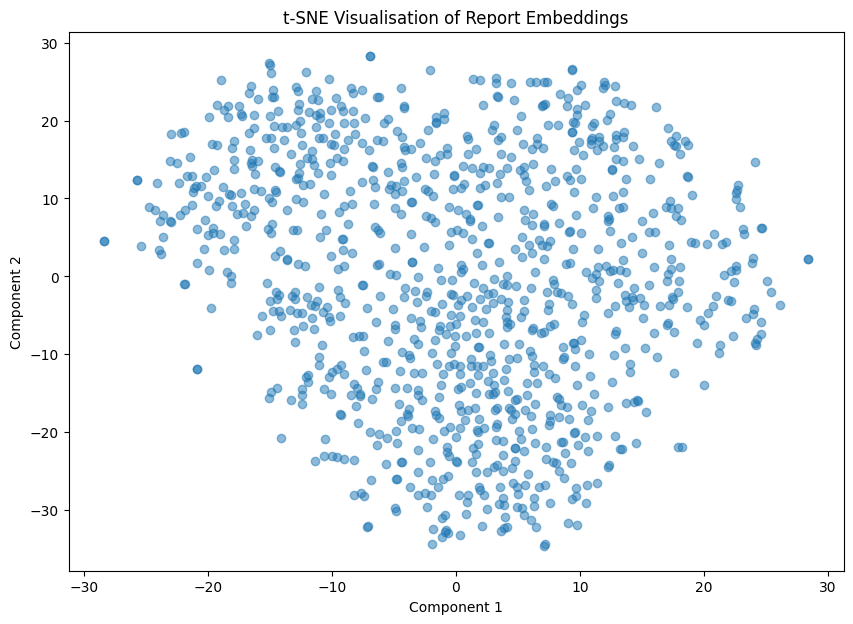

In [8]:
#visualise the embeddings with t-SNE (to read about)
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt

#make the embeddings 2d for plotting
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings) #reduced from 384 dimensional to 2 dimensional.

#plot
plt.figure(figsize =(10,7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title("t-SNE Visualisation of Report Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# looking for:
- tight clusters
- isolated outliers
- messy overlaps - incident types not seperated clearly

# Interperetation of Results:
- Dense cluster – Reports describing very similar failures. Could represent the same issue occurring across multiple flights.
- Two or more clusters close to each other – Likely the same root cause, but described differently due to:
- - Human error in reporting
- - Missing context
- - Different emphasis on symptoms
- Spread-out points – Incidents with very different narratives. This is expected and suggests the model is working well at distinguishing dissimilar cases.
- One large circular cluster – Indicates that the model is not identifying differences well enough. This may suggest the need for domain-specific fine-tuning to help it differentiate more effectively.

#### Key Observations (in note form):
Moderate clustering — There are some small patches where dots appear denser, and there is some overlap between them, particularly shown in:
- Upper right and left regions
- Middle/lower centre region

Suggests SBERT has picked up patterns such as:
- Root causes
- Flight phases during the incident
- Shared terminology (e.g. “take-off”, “approach”, “destination”)

No sharp clusters — The dataset may have high variance (especially in the Narrative column), so even where similarities exist, the model may not capture them as clearly. Likely due to:
- SBERT only capturing base-level semantic structure
- Lack of fine-tuning on aviation-specific language (as expected)

Outliers observed — Particularly in:
- Middle-left and middle-right regions

These may indicate:
- One-of-a-kind reports with highly distinct narratives
- Poorly written or very short entries (insufficient context)

>Note: This would be interesting to explore in a Failure Case section, potentially helping refine or adapt future models.     
   

- each point represents an incident report and the points are based on the SBERT embeddings. allows us to really understand what a Word2Vec does
- closer points mean their narratives are semantically similar
- farther apart means different meaning
- note that sbert focuses on meaning more than the words themselves - potentially training the model against aviation 'jargon' would increase semantic similarity accuracy?

In [ ]:
#proof the model works:

query_idx = 42 #just pick any random narrative row to retrieve the query from

results = get_similar_reports(query_idx, sample_embeddings, top_n=5)

print("\n--- Query Report ---\n")
print(df.iloc[query_idx]['Narrative'])

print("\n--- Top 5 similar reports ---\n")
for i, item in enumerate(results):
    idx = item[0]
    score = item[1]
    print(f"[{i+1}] Score: {score:.4f}")
    print(df.iloc[idx]['Narrative'], "\n---")

# Faliure Modes:

Despite its strengths, SBERT is a pretrained model and as a result exhibits several obvious limitations:

>False Positives / Weak Matches – Reports which may not be related semantically could be grouped with other narratives due to similar length, structure, and/or aviation-specific terminology used.

>Short or Vague Narratives – Human error also contributes to the reliability of the model’s functionality. If the narrative lacks specificity or context, the model will struggle to find accurate matches for it, and therefore the vector created could be interpreted as an outlier when examined under visual analysis using t-SNE or otherwise.

>Lack of Domain Fine-Tuning – The aviation industry uses a lot of corporate language and abbreviations which aren't used in general language. Therefore, the current SBERT model being used cannot semantically interpret the narratives and retrieve accurate similarity scores.

>Presence of Outliers – This could be due to either the aviation fault narrative being highly uncommon and completely unrelated to other narratives, or it could be due to human error in the proper creation of narratives.

# Future Work:

Despite the proof of model functionality in retrieving semantically similar narratives in the aviation domain, the current system is far from perfect and has several key areas for improvement that would significantly enhance its performance and applicability.

**Model Improvements:**  
SBERT is trained on general language, which lacks domain-specific terminology such as abbreviations, technical jargon, or aircraft model names.

1. **Fine-tune SBERT on domain-specific text** (e.g. FAA reports) to improve its semantic understanding of aviation data. This would allow better classification and clustering, potentially shown through enhanced visualisations compared to those in the current kernel.

2. **Contrastive Training** – Reimers & Gurevych (2020) show that training with semantically dissimilar pairs (hard negatives) significantly improves retrieval accuracy in sentence embedding models. They also used cosine similarity, reinforcing the credibility of this metric and methodology.

3. **Multimodal Expansion** – The assistant currently uses only textual narratives. A future version could integrate **image-based embeddings** (e.g. inspection photos or damage imagery) using CLIP or ViT models to retrieve across both text and visual data, especially in domains like aircraft maintenance or component inspection.

Additionally, a **GPT-style conversational layer** could be introduced, transforming the assistant into an interactive tool. Rather than returning a static list, the system could ask clarification questions, explain previous incident outcomes, or reference closure metadata — making it more intuitive and user-friendly.

4. **Interactive Feedback Loop** – Incorporating user feedback (e.g., tagging results as relevant or not) would enable the model to learn from domain experts and improve retrieval accuracy over time via supervised tuning.

5. **Metadata Fusion** – Important structured features (e.g., aircraft type, flight phase, weather) could be embedded alongside text to improve result relevance. Prior studies have shown combining structured + unstructured data enhances model accuracy in semantic retrieval.

6. **Noise Filtering via Weighted Similarity** – The assistant could benefit from a mechanism to down-rank filler content or overly generic sentence matches. By weighting fault-related keywords more heavily, results would better align with root cause analysis needs.

Such filtering would be especially useful for experienced engineers, transforming the tool from a generic suggestion system into a **precision aid** that delivers only operationally meaningful insights. Over time, using the feedback loop, the system could learn what expert users prioritise — and refine its ranking system accordingly.

7. **Real-World Evaluation via Industry Research** – As part of an upcoming internship with a **global leader in drilling tools and industrial solutions**, I will conduct interviews with professionals responsible for fault and incident analysis. These conversations will explore efficiency challenges and the impact of investigation delays on business outcomes.

This environment offers a real opportunity to test the assistant in operational settings — observing its performance under live conditions with large datasets, tight deadlines, and multiple users. This qualitative feedback will be critical to validate reliability and guide further development.

8. **Cross-Domain Generalisation** – Although this assistant is currently applied to aviation safety reports, the underlying methodology is transferable to other fields. It could benefit domains like manufacturing, logistics, and energy — where structured incident-resolution systems exist but remain underutilised for pattern recognition and semantic search.


# Conclusion: 
This project began as an attempt to build a simple fault assistant using sentence embeddings to retrieve similar incidents from a cleaned sample of the NASA ASRS dataset. At the time, I was still learning how SBERT worked, how cosine similarity functioned compared to other retrieval metrics, and even the basics of neural networks in order to better understand how transformers embed language. Through this process, I began to understand the inner workings of these models, and how they could be applied to real-world use cases.

The assistant encodes unstructured narratives using the models and metrics described. A t-SNE plot was used to visualise the embedding space, and a basic case study showed that the assistant could retrieve conceptually similar reports despite the variations of aviation language and no fine-tuning. This helped me understand the difference between lexical similarity and deeper semantic understanding.

Failure modes were identified and explored, such as the impact of short and vague reports, false positives, and the limitations of pretrained models. These were studied and leveraged to derive a next-steps section where I will be furthering my research, perhaps varying datasets and domains to discover which has the greatest real-world impact.

This project started with a newfound curiosity and ended in the creation of a functioning prototype that could one day be used in industry, solving a real and under-represented issue.

# References:
Mikolov, T., Chen, K., Corrado, G. and Dean, J., 2013. Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.

Reimers, N. and Gurevych, I., 2019. Sentence-BERT: Sentence embeddings using Siamese BERT-networks. arXiv preprint arXiv:1908.10084.

Reimers, N. and Gurevych, I., 2020. Making monolingual sentence embeddings multilingual using knowledge distillation. arXiv preprint arXiv:2004.09813.
